In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms

import shutil
import requests

from PIL import Image
import matplotlib.pyplot as plt 
import os

In [3]:
%mkdir test_data

urls = [
        r'https://storage.vsemayki.ru/images/0/1/1928/1928213/previews/people_4_manshortfull_front_white_500.jpg',
        r'https://storage.vsemayki.ru/images/0/2/2802/2802295/previews/people_14_manshortfull_front_white_500.jpg',
        r'https://contents.mediadecathlon.com/p1823349/ka488375539f5b5fe6eeb8789a8836e45/1823349_default.jpg?format=auto&quality=60&f=800x0',
        r'http://ae01.alicdn.com/kf/Habb5fa893e70454e9507e484d6f58ed9q.jpg_q50.jpg',
        r'https://qph.fs.quoracdn.net/main-qimg-80b12ce590101054ef09190b76ccd31f'
        ]

for ii, url in enumerate(urls):
    response = requests.get(url, stream=True)
    with open('test_data/img_test_' + str(ii) + '.jpg', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    
%ls test_data

img_test_0.jpg  img_test_1.jpg  img_test_2.jpg  img_test_3.jpg  img_test_4.jpg


In [4]:
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


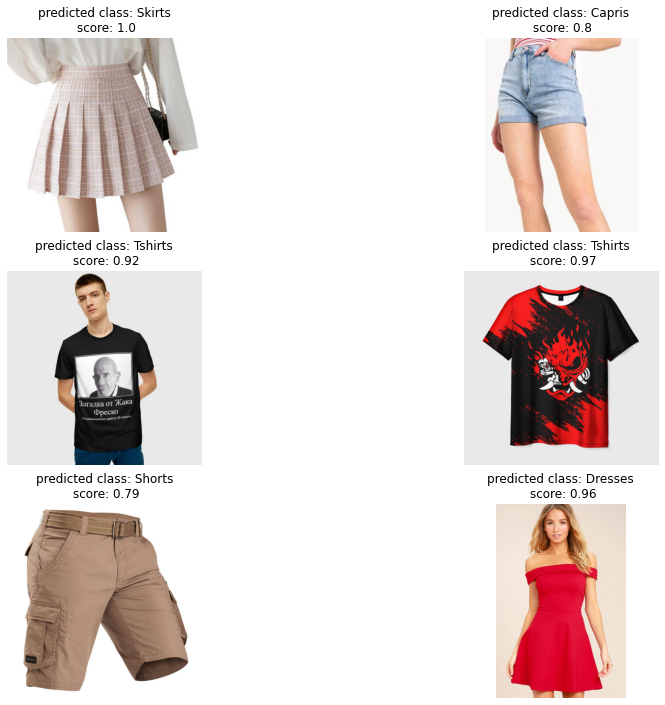

In [5]:
device = torch.device('cpu')
model = models.resnext101_32x8d(pretrained=True)    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 54)
model.load_state_dict(torch.load('/content/drive/MyDrive/ResNext101_32x8d_weights.pt', map_location=device))
model.eval()

class_names = ['Backpacks', 'Belts', 'Bra', 'Briefs', 'Capris', 'Caps', 'Casual Shoes', 
               'Clutches', 'Cufflinks', 'Deodorant', 'Dresses', 'Dupatta', 'Earrings', 
               'Flats', 'Flip Flops', 'Formal Shoes', 'Handbags', 'Heels', 'Innerwear Vests', 
               'Jackets', 'Jeans', 'Kajal and Eyeliner', 'Kurtas', 'Kurtis', 'Leggings', 
               'Lip Gloss', 'Lipstick', 'Nail Polish', 'Necklace and Chains', 'Night suits', 
               'Nightdress', 'Pendant', 'Perfume and Body Mist', 'Ring', 'Sandals', 'Sarees', 
               'Scarves', 'Shirts', 'Shorts', 'Skirts', 'Socks', 'Sports Shoes', 'Sunglasses', 
               'Sweaters', 'Sweatshirts', 'Ties', 'Tops', 'Track Pants', 'Trousers', 'Trunk', 
               'Tshirts', 'Tunics', 'Wallets', 'Watches']

fig = plt.figure(figsize=(15,25))

with torch.no_grad():

    for ii, file_name in enumerate(os.listdir( '/content/test_data' )):
        img = Image.open( '/content/test_data' + '/' + file_name)
        img_t = data_transforms['val'](img).unsqueeze(0)
        img_t = img_t.to(device)

        outputs = model(img_t)
        _, preds = torch.max(outputs, 1)
        prob = F.softmax(outputs, dim=1)
        top_p, top_class = prob.topk(1, dim = 1)

        ax = plt.subplot(len(os.listdir( '/content/test_data' )),2, ii+1)
        ax.axis('off')
        ax.set_title('predicted class: {}\n score: {}'.format(class_names[int(preds.cpu().numpy())], round(top_p.detach().cpu().numpy().tolist()[0][0],2)))
        plt.imshow(img)